In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from utils import LSTMModel, Optimization
import warnings
warnings.filterwarnings("ignore")

Input file is: both_sexes.csv


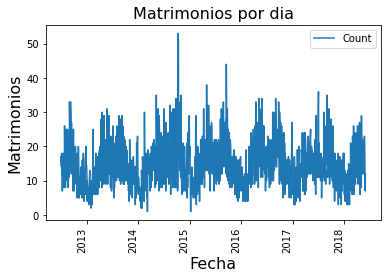

In [3]:
period=90

inputfile="both_sexes.csv"
print('Input file is:', inputfile)
df = pd.read_csv(inputfile)
df = df.set_index(pd.DatetimeIndex(df['RecDate']))
df.sort_index(ascending=True, inplace=True)
df["Count"] = 1
df = df["Count"]

df = df.groupby("RecDate").count()

matplotlib.rcParams['figure.figsize'] = [16,5]
plt.figure()
ax = df.plot(y='Count', rot=90)
ax.set_title("Matrimonios por dia", fontsize=16)
ax.set_ylabel("Matrimonios", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)
plt.legend(loc='best')
plt.show()

In [4]:
df_features = df.copy()
df_features = df_features.reset_index()
df_features['RecDate'] = df_features['RecDate'].astype('datetime64')

df_features = (
                df_features
                .assign(day = df_features['RecDate'].dt.day)
                .assign(month = df_features['RecDate'].dt.month)
                .assign(day_of_week = df_features['RecDate'].dt.dayofweek) 
                .assign(year = df_features['RecDate'].dt.year)
              )

df_features.drop(['RecDate'], axis=1, inplace=True)

df_features.head()

,Count,day,month,day_of_week,year
0,17,2,7,0,2012
1,15,3,7,1,2012
2,14,5,7,3,2012
3,18,6,7,4,2012
4,12,9,7,0,2012


In [5]:
y = df_features[["Count"]]
X = df_features.drop(columns=["Count"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [6]:
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

y_train_sc = scaler.fit_transform(y_train)
y_val_sc = scaler.transform(y_val)
y_test_sc = scaler.transform(y_test)

In [7]:
# Dataloaders
batch_size = 64

train_features = torch.Tensor(X_train_sc)
train_targets = torch.Tensor(y_train_sc)
val_features = torch.Tensor(X_val_sc)
val_targets = torch.Tensor(y_val_sc)
test_features = torch.Tensor(X_test_sc)
test_targets = torch.Tensor(y_test_sc)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

[1/500] Training loss: 0.1112	 Validation loss: 0.0904
[2/500] Training loss: 0.0370	 Validation loss: 0.0115
[3/500] Training loss: 0.0169	 Validation loss: 0.0125
[4/500] Training loss: 0.0157	 Validation loss: 0.0123
[5/500] Training loss: 0.0150	 Validation loss: 0.0117
[6/500] Training loss: 0.0153	 Validation loss: 0.0119
[7/500] Training loss: 0.0150	 Validation loss: 0.0116
[8/500] Training loss: 0.0151	 Validation loss: 0.0116
[9/500] Training loss: 0.0148	 Validation loss: 0.0114
[10/500] Training loss: 0.0149	 Validation loss: 0.0114
[11/500] Training loss: 0.0148	 Validation loss: 0.0114
[12/500] Training loss: 0.0148	 Validation loss: 0.0113
[13/500] Training loss: 0.0148	 Validation loss: 0.0112
[14/500] Training loss: 0.0149	 Validation loss: 0.0112
[15/500] Training loss: 0.0148	 Validation loss: 0.0111
[16/500] Training loss: 0.0148	 Validation loss: 0.0111
[17/500] Training loss: 0.0147	 Validation loss: 0.0110
[18/500] Training loss: 0.0146	 Validation loss: 0.0111
[

[148/500] Training loss: 0.0106	 Validation loss: 0.0087
[149/500] Training loss: 0.0106	 Validation loss: 0.0084
[150/500] Training loss: 0.0103	 Validation loss: 0.0085
[151/500] Training loss: 0.0104	 Validation loss: 0.0086
[152/500] Training loss: 0.0101	 Validation loss: 0.0088
[153/500] Training loss: 0.0103	 Validation loss: 0.0085
[154/500] Training loss: 0.0103	 Validation loss: 0.0087
[155/500] Training loss: 0.0104	 Validation loss: 0.0087
[156/500] Training loss: 0.0102	 Validation loss: 0.0085
[157/500] Training loss: 0.0103	 Validation loss: 0.0087
[158/500] Training loss: 0.0103	 Validation loss: 0.0087
[159/500] Training loss: 0.0101	 Validation loss: 0.0086
[160/500] Training loss: 0.0102	 Validation loss: 0.0089
[161/500] Training loss: 0.0103	 Validation loss: 0.0086
[162/500] Training loss: 0.0100	 Validation loss: 0.0089
[163/500] Training loss: 0.0103	 Validation loss: 0.0088
[164/500] Training loss: 0.0102	 Validation loss: 0.0088
[165/500] Training loss: 0.0104

[293/500] Training loss: 0.0087	 Validation loss: 0.0093
[294/500] Training loss: 0.0090	 Validation loss: 0.0093
[295/500] Training loss: 0.0089	 Validation loss: 0.0094
[296/500] Training loss: 0.0093	 Validation loss: 0.0092
[297/500] Training loss: 0.0088	 Validation loss: 0.0096
[298/500] Training loss: 0.0090	 Validation loss: 0.0093
[299/500] Training loss: 0.0088	 Validation loss: 0.0093
[300/500] Training loss: 0.0090	 Validation loss: 0.0094
[301/500] Training loss: 0.0091	 Validation loss: 0.0091
[302/500] Training loss: 0.0091	 Validation loss: 0.0093
[303/500] Training loss: 0.0089	 Validation loss: 0.0094
[304/500] Training loss: 0.0090	 Validation loss: 0.0095
[305/500] Training loss: 0.0091	 Validation loss: 0.0094
[306/500] Training loss: 0.0089	 Validation loss: 0.0097
[307/500] Training loss: 0.0089	 Validation loss: 0.0094
[308/500] Training loss: 0.0089	 Validation loss: 0.0094
[309/500] Training loss: 0.0090	 Validation loss: 0.0094
[310/500] Training loss: 0.0089

[437/500] Training loss: 0.0088	 Validation loss: 0.0093
[438/500] Training loss: 0.0087	 Validation loss: 0.0096
[439/500] Training loss: 0.0087	 Validation loss: 0.0096
[440/500] Training loss: 0.0088	 Validation loss: 0.0095
[441/500] Training loss: 0.0086	 Validation loss: 0.0094
[442/500] Training loss: 0.0084	 Validation loss: 0.0094
[443/500] Training loss: 0.0086	 Validation loss: 0.0097
[444/500] Training loss: 0.0088	 Validation loss: 0.0096
[445/500] Training loss: 0.0088	 Validation loss: 0.0094
[446/500] Training loss: 0.0085	 Validation loss: 0.0095
[447/500] Training loss: 0.0087	 Validation loss: 0.0095
[448/500] Training loss: 0.0086	 Validation loss: 0.0091
[449/500] Training loss: 0.0086	 Validation loss: 0.0095
[450/500] Training loss: 0.0089	 Validation loss: 0.0096
[451/500] Training loss: 0.0087	 Validation loss: 0.0095
[452/500] Training loss: 0.0088	 Validation loss: 0.0096
[453/500] Training loss: 0.0087	 Validation loss: 0.0098
[454/500] Training loss: 0.0087

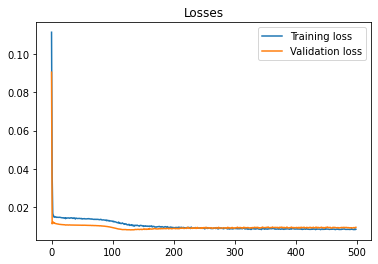

In [8]:
# Parametros del modelo
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 500
learning_rate = 1e-3
weight_decay = 1e-6

# Defino Modelo
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout)

# Defino Loss function
loss_fn = torch.nn.MSELoss(reduction="mean")

# Defino Optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Instancio clase para realizar el entrenamiento y evaluación
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

In [9]:
model.lstm

LSTM(4, 64, num_layers=3, batch_first=True, dropout=0.2)

In [18]:
print(model.fc)

Linear(in_features=64, out_features=1, bias=True)


In [10]:
predictions, original = opt.evaluate(test_loader, batch_size=1, n_features=input_dim)

In [11]:
# Funciones para re-escalar las predicciones (porque los datos estaban transformados con un scaler)
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


vals = np.concatenate(original, axis=0).ravel()
preds = np.concatenate(predictions, axis=0).ravel()

df_result = pd.DataFrame(data={"original": vals, "prediction": preds}, index=X_test.head(len(vals)).index)
df_result = df_result.sort_index()
df_result = inverse_transform(scaler, df_result, [["original", "prediction"]])
df_result

,original,prediction
1321,10.0,14.219378
1322,4.0,12.944888
1323,6.0,14.271577
1324,18.0,21.898100
1325,16.0,16.488384
...,...,...
1463,23.0,24.412483
1464,12.0,14.544848
1465,9.0,13.881768
1466,7.0,15.931796


In [12]:
# Preparo resultados para graficar
df_fecha = df.copy()
df_fecha = df_fecha.reset_index()
df_result['RecDate'] = df_fecha['RecDate'].astype('datetime64')
df_result = df_result.set_index('RecDate')

df_result.head()

,original,prediction
RecDate,,
2017-10-24,10.0,14.219378
2017-10-25,4.0,12.944888
2017-10-26,6.0,14.271577
2017-10-27,18.0,21.898100
2017-10-30,16.0,16.488384


Text(0.5, 1.0, 'Predicción con el dataset de Test')

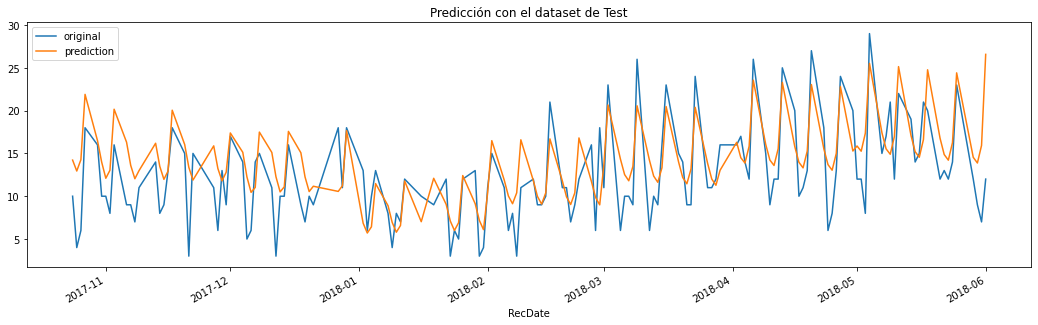

In [13]:
# Plot
df_result.plot(figsize=(18,5))
plt.title("Predicción con el dataset de Test")